# Web scraping with Selenium and BeautifulSoup: investigating the finanical performance of Palantir Tech

## Introduction

The objective of this project was to write an automated python script that investigates the financial performance, secifically revenue, of the publicly traded company "Palantir Technologies" over the financial years 2020 - 2024. This was a project that I created independently, having taught myself the required skills via online courses and independently led research.

# Tools

Selenium was used to navigate Palantirs investor relations webpage (https://investors.palantir.com/financials/quarterly-results), whilst BeautifulSoup was used to parse the HTML data and extract the relevant information. The data was then processed and cleaned, and presented in a simple graph using matplotlib. 

# To improve:

- The code is heavily tailored for one specific companies website. It would have been quicker to trawl through the page myself to find the data, this project serves best as a way to demonstrate the underlying skills.

- The code is quite fragile and if the webpage is interrupted whilst automation is in process errors are thrown.

- Automation could be sped up via more efficient scipting, e.g. many time.sleep(2.0) instances to avoid stale errors.

- Rather than storing the data in a simple list I could have used a pandas data frame which could store more information, for example the corresponding financial quarter for each revenue value rather than creating that list myself.

- The final plotting and presentation is simple, and could be further imprived by using a BI tool such as tableau.

In [1]:
# import relevant modules

# general
import os, time, csv, re
import matplotlib.pyplot as plt

# beautifulsoup
from bs4 import BeautifulSoup as bs

# selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException

## Webpage navigation and Data Extraction

In [2]:
# instantiate driver object and assign URL
driver = webdriver.Chrome()
driver.get('https://investors.palantir.com/financials/quarterly-results')


# initialize a list to store the extracted data
financial_data = []


# main loop
while True:
    try:
        # retrieve form elements - dropdown menu for financial year selection and year options
        year_dd = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'dropdown-select'))
        )
        year_options = year_dd.find_elements(By.TAG_NAME, "option")
        
        for i in range(len(year_options) - 1, -1, -1):
            # click on the current year
            year_options[i].click()
            time.sleep(2.0)

            # locate earnings release elements and filter for earnings reports
            earnings_release_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, 'report-resource-name'))
            )
            earnings_reports = [el for el in earnings_release_elements if "Earnings Release" in el.text]

            # nested loop: click on each year's quarterly earnings report, iterating in reverse order
            for report_index in range(len(earnings_reports) - 1, -1, -1):
                try:
                    # click the report
                    time.sleep(3.0)
                    earnings_reports[report_index].click()
                    time.sleep(2.0)

                    # parse the page using BeautifulSoup
                    soup = bs(driver.page_source, 'html.parser')

                    # find all <p> tags with the class 'bwalignr bwcellpmargin'
                    revenue_tags = soup.find_all('p', class_='bwalignr bwcellpmargin')

                    if revenue_tags:
                        # Check if the first tag contains a dollar sign
                        if revenue_tags[0].text.strip() == '$':
                            # if it's a dollar sign, look for revenue in the second p tag
                            if len(revenue_tags) > 1:
                                revenue = revenue_tags[1].text.strip()
                            else:
                                revenue = "Second p tag not found"
                        else:
                            # If the first p tag has numerical value, extract it directly
                            revenue = revenue_tags[0].text.strip()

                        financial_data.append(revenue)
                    else:
                        revenue = 0
                        financial_data.append(revenue)
                        print("No revenue tags found")
                        

                    # navigate back after interacting with the report
                    driver.back()
                    time.sleep(2.0)

                    # re-select the same year again to refresh the DOM
                    year_dd = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CLASS_NAME, 'dropdown-select'))
                    )
                    year_options = year_dd.find_elements(By.TAG_NAME, "option")
                    year_options[i].click()
                    time.sleep(2.0)

                    # re-fetch the earnings release elements
                    earnings_release_elements = WebDriverWait(driver, 10).until(
                        EC.presence_of_all_elements_located((By.CLASS_NAME, 'report-resource-name'))
                    )
                    earnings_reports = [el for el in earnings_release_elements if "Earnings Release" in el.text]
                    
                # if we encounter a stale element, break the inner loop and move to the next year
                except (StaleElementReferenceException, TimeoutException):
                    break

        # break the outer loop if we've successfully processed all years
        break
    # if we encounter a stale element or timeout in the outer loop, refresh the page and try again
    except (StaleElementReferenceException, TimeoutException):
        driver.refresh()
        time.sleep(2.0)

driver.quit()
print(financial_data)

No revenue tags found
['289,366', '322,091', '341,234', '375,642', '392,146', '432,867', '446,357', '473,010', 0, '508,624', '525,186', '533,317', '558,159', '608,350', '634,338', '678,134']


## Data Processing, Cleaning and Plotting

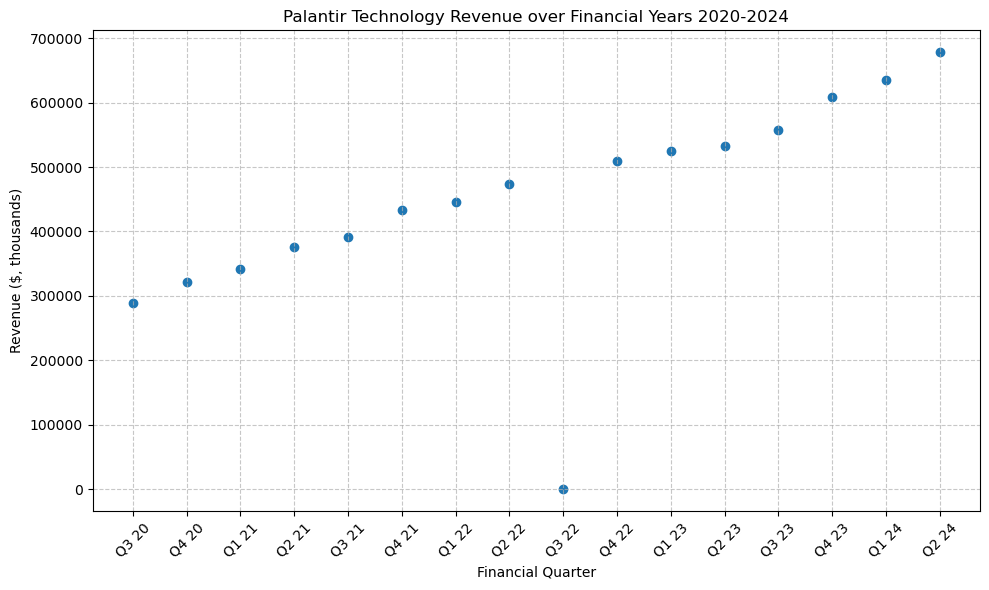

In [3]:
# initialise empty lists for future lists
financial_data_cleaned = []
financial_data_converted = []
time = ['Q3 20', 'Q4 20', 'Q1 21', 'Q2 21', 'Q3 21', 'Q4 21', 'Q1 22', 'Q2 22','Q3 22', 'Q4 22', 'Q1 23', 'Q2 23', 'Q3 23', 'Q4 23', 'Q1 24', 'Q2 24']

# clean data by removing commas and converting to float from either int or str
for item in financial_data:
    if isinstance(item, str):
        cleaned_string = item.replace(',', '')
        financial_data_cleaned.append(cleaned_string)
        financial_data_converted.append(float(cleaned_string))
    elif isinstance(item, int):
        financial_data_cleaned.append(str(item))
        financial_data_converted.append(float(item))

# create plot
plt.figure(figsize=(10, 6))
plt.scatter(time, financial_data_converted, marker='o')
plt.title('Palantir Technology Revenue over Financial Years 2020-2024')
plt.xlabel('Financial Quarter')
plt.ylabel('Revenue ($, thousands)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()